# Stochastic Gradient Descent (SGD) and Nabla (∇) Explained

This notebook contains the explanation of SGD and the gradient operator (nabla, `∇`) with multiple, runnable examples.

Contents:
- What is SGD? Variants of gradient descent (expanded)
- Notation: θ (parameters), η (learning rate), ∇ (gradient)
- What is `∇` and how is it computed (backpropagation)
- Example 1: 1D quadratic gradient descent with autograd
- Example 2: `loss.backward()` computes gradients
- Example 3: Manual SGD step vs `torch.optim.SGD`
- Example 4: Batch vs mini-batch gradient noise
- Example 5: Learning rate sweep
- Example 6: Full-batch vs mini-batch vs single-sample — loss per parameter update
- Example 7: Effect of shuffling vs no shuffling
- Example 8: Gradient accumulation to emulate larger batches
- Example 9: SGD vs SGD with momentum vs Nesterov


## What is Stochastic Gradient Descent (SGD)?

Stochastic Gradient Descent is an optimization algorithm used to minimize a loss function during neural network training. Unlike standard (batch) gradient descent which uses the entire dataset to compute gradients, SGD updates model parameters using gradients from small batches of data (or even single examples).

### Gradient Descent Variants
1. **Batch Gradient Descent (Full-batch)**: Uses the entire dataset to compute the gradient each update.
   - Pros: Stable gradients; deterministic loss curve per epoch; good for convex problems and small datasets.  
   - Cons: Expensive per update; few parameter updates per epoch; can get stuck or be slow on non-convex landscapes.  
   - Update: $\theta \leftarrow \theta - \eta \cdot \nabla_\theta J(\theta)$ using all training examples.

2. **Stochastic Gradient Descent (SGD, single-sample)**: Uses one randomly sampled example per update.
   - Pros: Very frequent updates; gradient noise can help escape shallow minima/saddles; memory efficient.  
   - Cons: Very noisy objective; requires careful learning-rate schedules.  
   - Update: $\theta \leftarrow \theta - \eta \cdot \nabla_\theta J(\theta; x^{(i)}, y^{(i)})$.

3. **Mini-batch Gradient Descent**: Uses a small batch (e.g., 32, 64, 128) per update.
   - Pros: Strong practical default; good hardware utilization; balances noise and stability.  
   - Cons: Too large batches can reduce generalization and require LR tuning.

Practical notes:
- Shuffle training data at the start of each epoch to ensure IID mini-batches.
- Terminology: 1 epoch = 1 pass through the dataset; 1 iteration/step = 1 optimizer update. For batch size `B` and dataset size `N`, steps per epoch ≈ `ceil(N/B)`.
- Learning rate interacts with batch size; larger batches often need a higher LR (linear scaling rule is a common heuristic).
- Gradient accumulation can emulate larger batch sizes if memory is limited.


## Notation
- $\theta$: All model parameters (weights, biases) we want to optimize.
- $\eta$: Learning rate (hyperparameter you set).
- $\nabla_\theta$: Gradient operator w.r.t. parameters $\theta$.

## Understanding Nabla (∇) — The Gradient
`∇` is a mathematical operator that represents the gradient — a vector of partial derivatives. For a scalar loss $L(\theta)$ with parameters $\theta = [\theta_1, \dots, \theta_n]$, the gradient is:
$$ \nabla_\theta L = \begin{bmatrix} \frac{\partial L}{\partial \theta_1} \\ \frac{\partial L}{\partial \theta_2} \\ \vdots \\ \frac{\partial L}{\partial \theta_n} \end{bmatrix}$$

### How is ∇ computed in deep learning?
During training we perform a forward pass to compute the loss, then a backward pass that applies the chain rule (backpropagation) to compute all partial derivatives. In PyTorch, calling `loss.backward()` computes `∇` for all parameters with `requires_grad=True`.

Parameter updates use the rule: $\theta \leftarrow \theta - \eta \cdot \nabla_\theta L$.

Practical PyTorch notes:
- Set `requires_grad=True` on tensors you want gradients for (typically model parameters). Modules like `nn.Linear` register parameters with this set already.
- Gradients accumulate by default. Call `optimizer.zero_grad()` (preferred) or `param.grad.zero_()` each iteration before `backward()`.
- Use `with torch.no_grad():` when updating parameters manually to avoid tracking these ops in the graph.
- After `.backward()`, gradients are stored in `param.grad`. The computation graph is freed by default; set `retain_graph=True` only if you need multiple backward passes through the same graph in one iteration.
- For inference/evaluation, wrap code in `torch.inference_mode()` or `torch.no_grad()` to save memory and compute.

## Example 1: Gradient Descent on a 1D Quadratic (autograd)
We minimize $f(w) = (w - 3)^2$ using PyTorch tensors and autograd. The analytical gradient is $f'(w) = 2(w-3)$, and autograd will recover the same derivative.


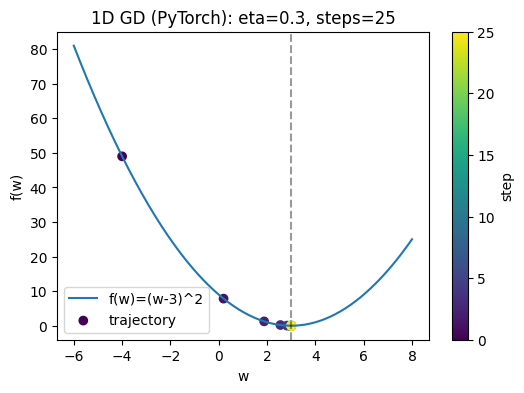

Final w: 3.0


In [1]:
import torch
import matplotlib.pyplot as plt

def f_torch(w):
    return (w - 3.0)**2

w = torch.tensor([-4.0], requires_grad=True)
eta = 0.3
history_w = [w.item()]
for t in range(25):
    loss = f_torch(w)
    loss.backward()
    with torch.no_grad():
        w -= eta * w.grad
    w.grad.zero_()
    history_w.append(w.item())

ws = torch.linspace(-6, 8, 200)
plt.figure(figsize=(6,4))
plt.plot(ws.numpy(), f_torch(ws).numpy(), label="f(w)=(w-3)^2")
plt.scatter(history_w, [float(f_torch(torch.tensor(h))) for h in history_w], c=range(len(history_w)), cmap='viridis', label='trajectory')
plt.colorbar(label='step')
plt.axvline(3, color='k', ls='--', alpha=0.4)
plt.title(f'1D GD (PyTorch): eta={eta}, steps={len(history_w)-1}')
plt.xlabel('w'); plt.ylabel('f(w)'); plt.legend(); plt.show()
print('Final w:', w.item())

---
## Example 2: `loss.backward()` Computes ∇
A simple logistic regression with a single parameter shows that `w.grad` is populated after `loss.backward()`.


In [ ]:
import torch
import torch.nn.functional as F

w = torch.tensor([2.2], requires_grad=True)
x = torch.tensor([1.1])
y_true = torch.tensor([1.0])

y_pred = torch.sigmoid(w * x)
loss = F.binary_cross_entropy(y_pred, y_true)

loss.backward()  # computes ∇ with respect to w
print('Loss:', float(loss))
print('∇_w L (w.grad):', float(w.grad))


## Example 3: Manual SGD Step vs `torch.optim.SGD`
We show two equivalent ways to update parameters: doing it manually with `torch.no_grad()` and using `torch.optim.SGD`.

In [ ]:
import torch

# Simple linear model y = wx + b
w = torch.tensor([0.5], requires_grad=True)
b = torch.tensor([0.0], requires_grad=True)
x = torch.linspace(-1, 1, 21).unsqueeze(1)
y_true = 2.0 * x + 0.3  # target: w=2.0, b=0.3

def mse(yhat, y): return ((yhat - y)**2).mean()

# Manual step
for _ in range(50):
    yhat = w * x + b
    loss = mse(yhat, y_true)
    loss.backward()
    with torch.no_grad():
        w -= 0.1 * w.grad
        b -= 0.1 * b.grad
        w.grad.zero_()
        b.grad.zero_()
print('Manual step → w,b ≈', float(w), float(b))

# Reset and use torch.optim.SGD
w2 = torch.tensor([0.5], requires_grad=True)
b2 = torch.tensor([0.0], requires_grad=True)
opt = torch.optim.SGD([w2, b2], lr=0.1)
for _ in range(50):
    opt.zero_grad()
    yhat2 = w2 * x + b2
    loss2 = mse(yhat2, y_true)
    loss2.backward()
    opt.step()
print('Optimizer step → w,b ≈', float(w2), float(b2))


## Example 4 (PyTorch): Batch vs Mini-batch Gradient Noise
We compare a single step update using the full batch vs random mini-batches and visualize the variability (noise) in updates.

In [ ]:
import torch
torch.manual_seed(0)

# Synthetic linear data with noise
N, D = 512, 5
true_W = torch.randn(D, 1)
true_b = torch.randn(1)
X = torch.randn(N, D)
y = X @ true_W + true_b + 0.1 * torch.randn(N, 1)

W = torch.zeros(D, 1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

def mse(yhat, y): return ((yhat - y)**2).mean()

# Full-batch gradient
yhat = X @ W + b
loss = mse(yhat, y)
loss.backward()
gW_full = W.grad.detach().clone(); gb_full = b.grad.detach().clone()
W.grad.zero_(); b.grad.zero_()

# Mini-batch gradients over several random batches
batch_size = 32
num_batches = 50
gW_list = []
for _ in range(num_batches):
    idx = torch.randint(0, N, (batch_size,))
    Xb, yb = X[idx], y[idx]
    yhat_b = Xb @ W + b
    loss_b = mse(yhat_b, yb)
    loss_b.backward()
    gW_list.append(W.grad.detach().clone())
    W.grad.zero_(); b.grad.zero_()

gW_stack = torch.stack(gW_list)  # [num_batches, D, 1]
per_dim_std = gW_stack.squeeze(-1).std(dim=0)
per_dim_mean = gW_stack.squeeze(-1).mean(dim=0)

print('Full-batch gradient norm:', gW_full.norm().item())
print('Mini-batch gradient mean norm:', per_dim_mean.norm().item())
print('Mini-batch gradient per-dimension std:', per_dim_std.tolist())


## Example 5: Learning Rate Sweep
We train a 2D linear model with different learning rates to see convergence vs divergence.

In [ ]:
import torch
import matplotlib.pyplot as plt
torch.manual_seed(0)

# Data
N, D = 200, 2
W_true = torch.tensor([[2.0],[ -1.0]])
b_true = torch.tensor([0.5])
X = torch.randn(N, D)
y = X @ W_true + b_true + 0.1 * torch.randn(N, 1)

lrs = [0.001, 0.01, 0.1, 0.5]
epochs = 50
histories = {}

for lr in lrs:
    W = torch.zeros(D, 1, requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    opt = torch.optim.SGD([W, b], lr=lr)
    losses = []
    for _ in range(epochs):
        opt.zero_grad()
        yhat = X @ W + b
        loss = ((yhat - y)**2).mean()
        loss.backward()
        opt.step()
        losses.append(float(loss))
    histories[lr] = losses

plt.figure(figsize=(6,4))
for lr, losses in histories.items():
    plt.plot(losses, label=f'lr={lr}')
plt.yscale('log')
plt.xlabel('epoch'); plt.ylabel('MSE (log)'); plt.title('Learning rate sweep')
plt.legend(); plt.show()


## Example 6: Full-batch vs Mini-batch vs Single-sample, loss per parameter update
We train the same linear model using three update strategies and compare loss versus number of parameter updates (not epochs).

In [ ]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(0)
N, D = 512, 10
W_true = torch.randn(D, 1)
b_true = torch.randn(1)
X = torch.randn(N, D)
y = X @ W_true + b_true + 0.1 * torch.randn(N, 1)

# Helper
def mse(yhat, y):
    return ((yhat - y) ** 2).mean()

def run_strategy(batch_size, max_updates=200):
    W = torch.zeros(D, 1, requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    opt = torch.optim.SGD([W, b], lr=0.1)
    losses = []
    updates = 0
    while updates < max_updates:
        # Iterate over dataset in batches of batch_size
        perm = torch.randperm(N)
        for i in range(0, N, batch_size):
            idx = perm[i:i+batch_size]
            Xb, yb = X[idx], y[idx]
            opt.zero_grad()
            yhat = Xb @ W + b
            loss = mse(yhat, yb)
            loss.backward()
            opt.step()
            losses.append(float(loss))
            updates += 1
            if updates >= max_updates:
                break
    return losses

loss_full   = run_strategy(batch_size=N,   max_updates=120)
loss_minib  = run_strategy(batch_size=32,  max_updates=120)
loss_single = run_strategy(batch_size=1,   max_updates=120)

plt.figure(figsize=(6,4))
plt.plot(loss_full,   label='Full-batch (B=N)')
plt.plot(loss_minib,  label='Mini-batch (B=32)')
plt.plot(loss_single, label='Single-sample (B=1)', alpha=0.8)
plt.yscale('log')
plt.xlabel('update step')
plt.ylabel('MSE (log)')
plt.title('Loss vs parameter updates')
plt.legend(); plt.show()


## Example 7: Effect of Shuffling vs No Shuffling
We compare training with `shuffle=True` versus iterating over the same order every epoch. Shuffling typically improves convergence by making mini-batches more IID.

In [ ]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(1)
N, D = 400, 5
X = torch.randn(N, D)
true_W = torch.randn(D, 1)
true_b = torch.randn(1)
y = X @ true_W + true_b + 0.2 * torch.randn(N, 1)

epochs = 10
batch_size = 32

# No shuffle
def train_no_shuffle():
    W = torch.zeros(D, 1, requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    opt = torch.optim.SGD([W, b], lr=0.1)
    hist = []
    for _ in range(epochs):
        for i in range(0, N, batch_size):
            idx = torch.arange(i, min(i+batch_size, N))
            Xb, yb = X[idx], y[idx]
            opt.zero_grad(); loss = ((Xb @ W + b - yb)**2).mean(); loss.backward(); opt.step(); hist.append(float(loss))
    return hist

# Shuffle each epoch
def train_shuffle():
    W = torch.zeros(D, 1, requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    opt = torch.optim.SGD([W, b], lr=0.1)
    hist = []
    for _ in range(epochs):
        perm = torch.randperm(N)
        for i in range(0, N, batch_size):
            idx = perm[i:i+batch_size]
            Xb, yb = X[idx], y[idx]
            opt.zero_grad(); loss = ((Xb @ W + b - yb)**2).mean(); loss.backward(); opt.step(); hist.append(float(loss))
    return hist

hist_no_shuffle = train_no_shuffle()
hist_shuffle    = train_shuffle()

plt.figure(figsize=(6,4))
plt.plot(hist_no_shuffle, label='no shuffle')
plt.plot(hist_shuffle, label='shuffle=True')
plt.yscale('log'); plt.xlabel('update step'); plt.ylabel('MSE (log)'); plt.title('Shuffling effect')
plt.legend(); plt.show()


## Example 8: Gradient Accumulation (simulate larger batch)
When memory is limited, you can accumulate gradients over `k` micro-batches before calling `optimizer.step()`, which approximates using a batch size `k * micro_batch`.

In [ ]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(2)
N, D = 600, 8
X = torch.randn(N, D)
true_W = torch.randn(D, 1)
true_b = torch.randn(1)
y = X @ true_W + true_b + 0.2 * torch.randn(N, 1)

micro_batch = 16
acc_steps = 4  # effective batch size = 64
lr = 0.05

W = torch.zeros(D, 1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)
opt = torch.optim.SGD([W, b], lr=lr)
loss_hist_acc = []

for epoch in range(5):
    perm = torch.randperm(N)
    for start in range(0, N, micro_batch):
        idx = perm[start:start+micro_batch]
        Xb, yb = X[idx], y[idx]
        yhat = Xb @ W + b
        loss = ((yhat - yb)**2).mean() / acc_steps  # scale loss to keep gradients comparable
        loss.backward()
        if ((start // micro_batch) + 1) % acc_steps == 0:
            opt.step(); opt.zero_grad()
        loss_hist_acc.append(float(loss) * acc_steps)

plt.figure(figsize=(6,4))
plt.plot(loss_hist_acc, label='accumulated grads (eff. B=64)')
plt.yscale('log'); plt.xlabel('micro-batch step'); plt.ylabel('MSE (log)'); plt.title('Gradient accumulation')
plt.legend(); plt.show()


## Example 9: SGD vs Momentum vs Nesterov
We compare plain SGD, SGD with momentum, and Nesterov momentum on the same task.

In [ ]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(3)
N, D = 300, 6
X = torch.randn(N, D)
true_W = torch.randn(D, 1)
true_b = torch.randn(1)
y = X @ true_W + true_b + 0.2 * torch.randn(N, 1)

configs = [
    ("SGD", dict(lr=0.05, momentum=0.0, nesterov=False)),
    ("Momentum 0.9", dict(lr=0.05, momentum=0.9, nesterov=False)),
    ("Nesterov 0.9", dict(lr=0.05, momentum=0.9, nesterov=True)),
]

def train_cfg(cfg):
    W = torch.zeros(D, 1, requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    opt = torch.optim.SGD([W, b], **cfg)
    losses = []
    for epoch in range(15):
        perm = torch.randperm(N)
        for i in range(0, N, 32):
            idx = perm[i:i+32]
            Xb, yb = X[idx], y[idx]
            opt.zero_grad()
            yhat = Xb @ W + b
            loss = ((yhat - yb)**2).mean()
            loss.backward(); opt.step()
            losses.append(float(loss))
    return losses

histories = {name: train_cfg(params) for name, params in configs}

plt.figure(figsize=(6,4))
for name, losses in histories.items():
    plt.plot(losses, label=name)
plt.yscale('log'); plt.xlabel('update step'); plt.ylabel('MSE (log)'); plt.title('SGD variants')
plt.legend(); plt.show()


## Key Takeaways
- `∇` (nabla) denotes the vector of partial derivatives (the gradient).
- In PyTorch, `loss.backward()` computes gradients for all parameters with `requires_grad=True`.
- SGD updates parameters using $\theta \leftarrow \theta - \eta \cdot \nabla_\theta L$.
- Mini-batch gradients are noisy estimates of the full gradient; this noise can be beneficial.
- Learning rate critically affects convergence: too small → slow; too large → divergence.